# Finite window bootstrap error

Estimate the error of our interior time estimator using bootstrapping for various trajectory counts.

In [1]:
import matplotlib as mpl
import numpy as np

import multi_locus_analysis as mla
import multi_locus_analysis.finite_window as fw
import multi_locus_analysis.plotting.finite_window as fplt
import bruno_util.plotting as bplt

figure_size = bplt.use_cell_style(mpl.rcParams)

In [2]:
from multi_locus_analysis.plotting import Variable
from scipy.stats import beta, expon
import seaborn as sns

variable_pairs = {}
windows = {}

# for Beta distributions, making the window size a little less than 1 guarantees there's not too many,
# and also not too fewobs per trajectory, so that the effect we want to show is visible
window = 0.8
var_pair = [
    Variable(beta(5, 2), 
             name='Beta(5, 2)',
             pretty_name=r'Beta$(\alpha{}=5, \beta{}=2)$', 
             linestyle=':', 
             color=sns.color_palette('colorblind')[2],
             scaled_ylim=4.0),
    Variable(beta(2, 2),
             name='Beta(2, 2)',
             pretty_name=r'Beta$(\alpha{}=2, \beta{}=2)$', 
             linestyle='--', 
             color=sns.color_palette('colorblind')[3],
             scaled_ylim=2.0)
]


windows['exp'] = 2 + 4 + 2
variable_pairs['exp'] = [
    Variable(expon(scale=4), 
             name=f'Exp(4)', 
             linestyle=':', 
             color=sns.color_palette('colorblind')[4],
             scaled_ylim=0.3),
    Variable(expon(loc=2, scale=2), 
             name=f'Exp(2) + 2', 
             linestyle='--', 
             color=sns.color_palette('colorblind')[5],
             scaled_ylim=0.5)
]

In [17]:
%%time
N_boot = 100
N_traj_per_boot = 1_000

err_t = np.linspace(0, window, 101)
err_ave = {var.name: np.zeros_like(err_t) for var in var_pair}
err_ave_dumb = {var.name: np.zeros_like(err_t) for var in var_pair}
err_std = {var.name: np.zeros_like(err_t) for var in var_pair}
for i in range(N_boot):
    print('Running bootstrap sample #' + str(i))
    sim = fw.ab_window(
        [var.rvs for var in var_pair],
        offset=-100*np.sum([var.mean() for var in var_pair]),
        window_size=window, 
        num_replicates=N_traj_per_boot,  
        states=[var.name for var in var_pair]
    )
    obs = fw.sim_to_obs(sim)
    for var in var_pair:
        interior = obs.loc[
            (obs['state'] == var.name) & (obs['wait_type'] == 'interior'),
            ['wait_time', 'window_size']
        ].copy()
        exterior = obs.loc[
                (obs['state'] == var.name)
                & (obs['wait_type'] != 'interior')
                & (obs['wait_type'] != 'full exterior'),
                ['wait_time', 'window_size']
        ].copy()
        window_sizes = obs.groupby(traj_cols)['window_size'].first().values
        # now sorted
        window_sizes, window_cdf = stats.ecdf(window_sizes)
        window_sf = 1 - window_cdf
        all_times, cdf_int, cdf_ext, Z_X, F_T = fw.ecdf_ext_int(
            exterior.wait_time.values,
            interior.wait_time.values,
            interior.window_size.values
        )
        res = np.interp(err_t, all_times, var.cdf(all_times) - cdf_int*F_T) 
        # simultaneous streaming mean and standard deviation, by Knuth
        # https://math.stackexchange.com/questions/198336/how-to-calculate-standard-deviation-with-streaming-inputs
        delta = res - err_ave[var.name]
        err_ave[var.name] += delta/(i + 1)
        err_std[var.name] += delta*(res - err_ave[var.name])
        err_ave_dumb[var.name] += (1/N_boot) * res
for name in err_std:
    err_std[name] /= i

Running bootstrap sample #0
Running bootstrap sample #1
Running bootstrap sample #2
Running bootstrap sample #3
Running bootstrap sample #4
Running bootstrap sample #5
Running bootstrap sample #6
Running bootstrap sample #7
Running bootstrap sample #8
Running bootstrap sample #9
Running bootstrap sample #10
Running bootstrap sample #11
Running bootstrap sample #12
Running bootstrap sample #13
Running bootstrap sample #14
Running bootstrap sample #15
Running bootstrap sample #16
Running bootstrap sample #17
Running bootstrap sample #18
Running bootstrap sample #19
Running bootstrap sample #20
Running bootstrap sample #21
Running bootstrap sample #22
Running bootstrap sample #23
Running bootstrap sample #24
Running bootstrap sample #25
Running bootstrap sample #26
Running bootstrap sample #27
Running bootstrap sample #28
Running bootstrap sample #29
Running bootstrap sample #30
Running bootstrap sample #31
Running bootstrap sample #32
Running bootstrap sample #33
Running bootstrap sample

In [42]:

    
def boot_int(N_traj_per_boot=1_000, var_pair):
    sim = fw.ab_window(
        [var.rvs for var in var_pair],
        offset=-100*np.sum([var.mean() for var in var_pair]),
        window_size=window, 
        num_replicates=N_traj_per_boot,  
        states=[var.name for var in var_pair]
    )
    obs = fw.sim_to_obs(sim)
    res = {}
    for var in var_pair:
        interior = obs.loc[
            (obs['state'] == var.name) & (obs['wait_type'] == 'interior'),
            ['wait_time', 'window_size']
        ].copy()
        exterior = obs.loc[
                (obs['state'] == var.name)
                & (obs['wait_type'] != 'interior')
                & (obs['wait_type'] != 'full exterior'),
                ['wait_time', 'window_size']
        ].copy()
        window_sizes = obs.groupby(traj_cols)['window_size'].first().values
        # now sorted
        window_sizes, window_cdf = stats.ecdf(window_sizes)
        window_sf = 1 - window_cdf
        all_times, cdf_int, cdf_ext, Z_X, F_T = fw.ecdf_ext_int(
            exterior.wait_time.values,
            interior.wait_time.values,
            interior.window_size.values
        )
        res[var.name] = np.interp(err_t, all_times, var.cdf(all_times) - cdf_int*F_T)
    return res

In [44]:
%%time

from multiprocessing import Pool, cpu_count
N_boot = 10000

err_t = np.linspace(0, window, 101)
err_ave = {var.name: np.zeros_like(err_t) for var in var_pair}
err_std = {var.name: np.zeros_like(err_t) for var in var_pair}

def accumulate_ave_std(res):
    accumulate_ave_std.N += 1
    for name in res:
        delta = res[name] - err_ave[name]
        err_ave[name] += delta/accumulate_ave_std.N
        err_std[name] += delta*(res[name] - err_ave[name])
accumulate_ave_std.N = 0

with Pool(processes=cpu_count()) as pool:
    lazy_res = [
        pool.apply_async(boot_int, (N_traj_per_boot,)) 
        for i in range(N_boot)
    ]
    for res in lazy_res:
        accumulate_ave_std(res.get())

for name in err_std:
    err_std[name] /= accumulate_ave_std.N - 1

In [8]:
import matplotlib.pyplot as plt

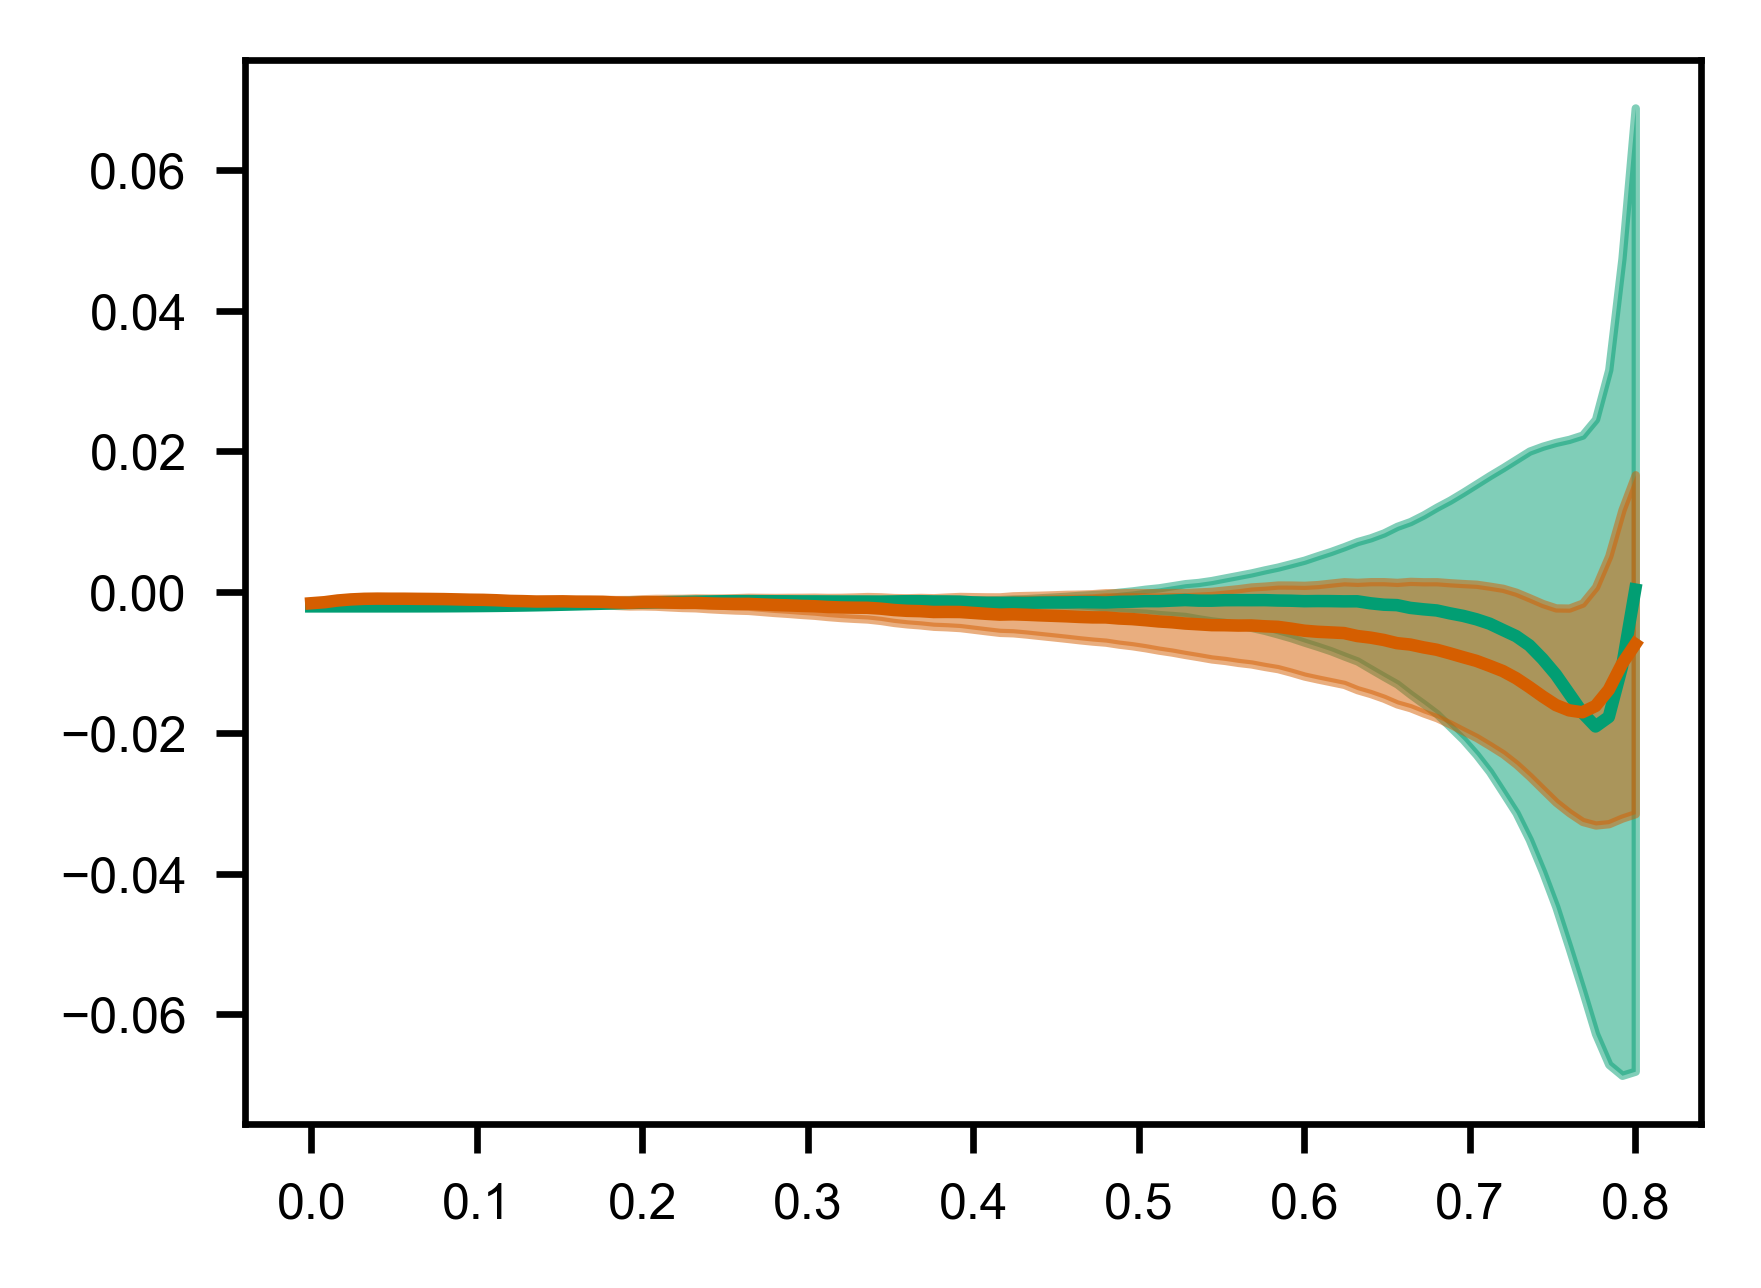

In [45]:
fig, ax = plt.subplots()
for var in var_pair:
    ax.plot(err_t, err_ave[var.name], c=var.color)
    ax.fill_between(
        err_t, 
        err_ave[var.name] - 2*err_std[var.name],
        err_ave[var.name] + 2*err_std[var.name],
        alpha=0.5,
        color=var.color
    )
    

In [47]:
import pickle

In [50]:
with open('/home/bbeltr1/Downloads/int_err_boot_1000_traj.pkl', 'wb') as f:
    pickle.dump((err_ave, err_std), f)

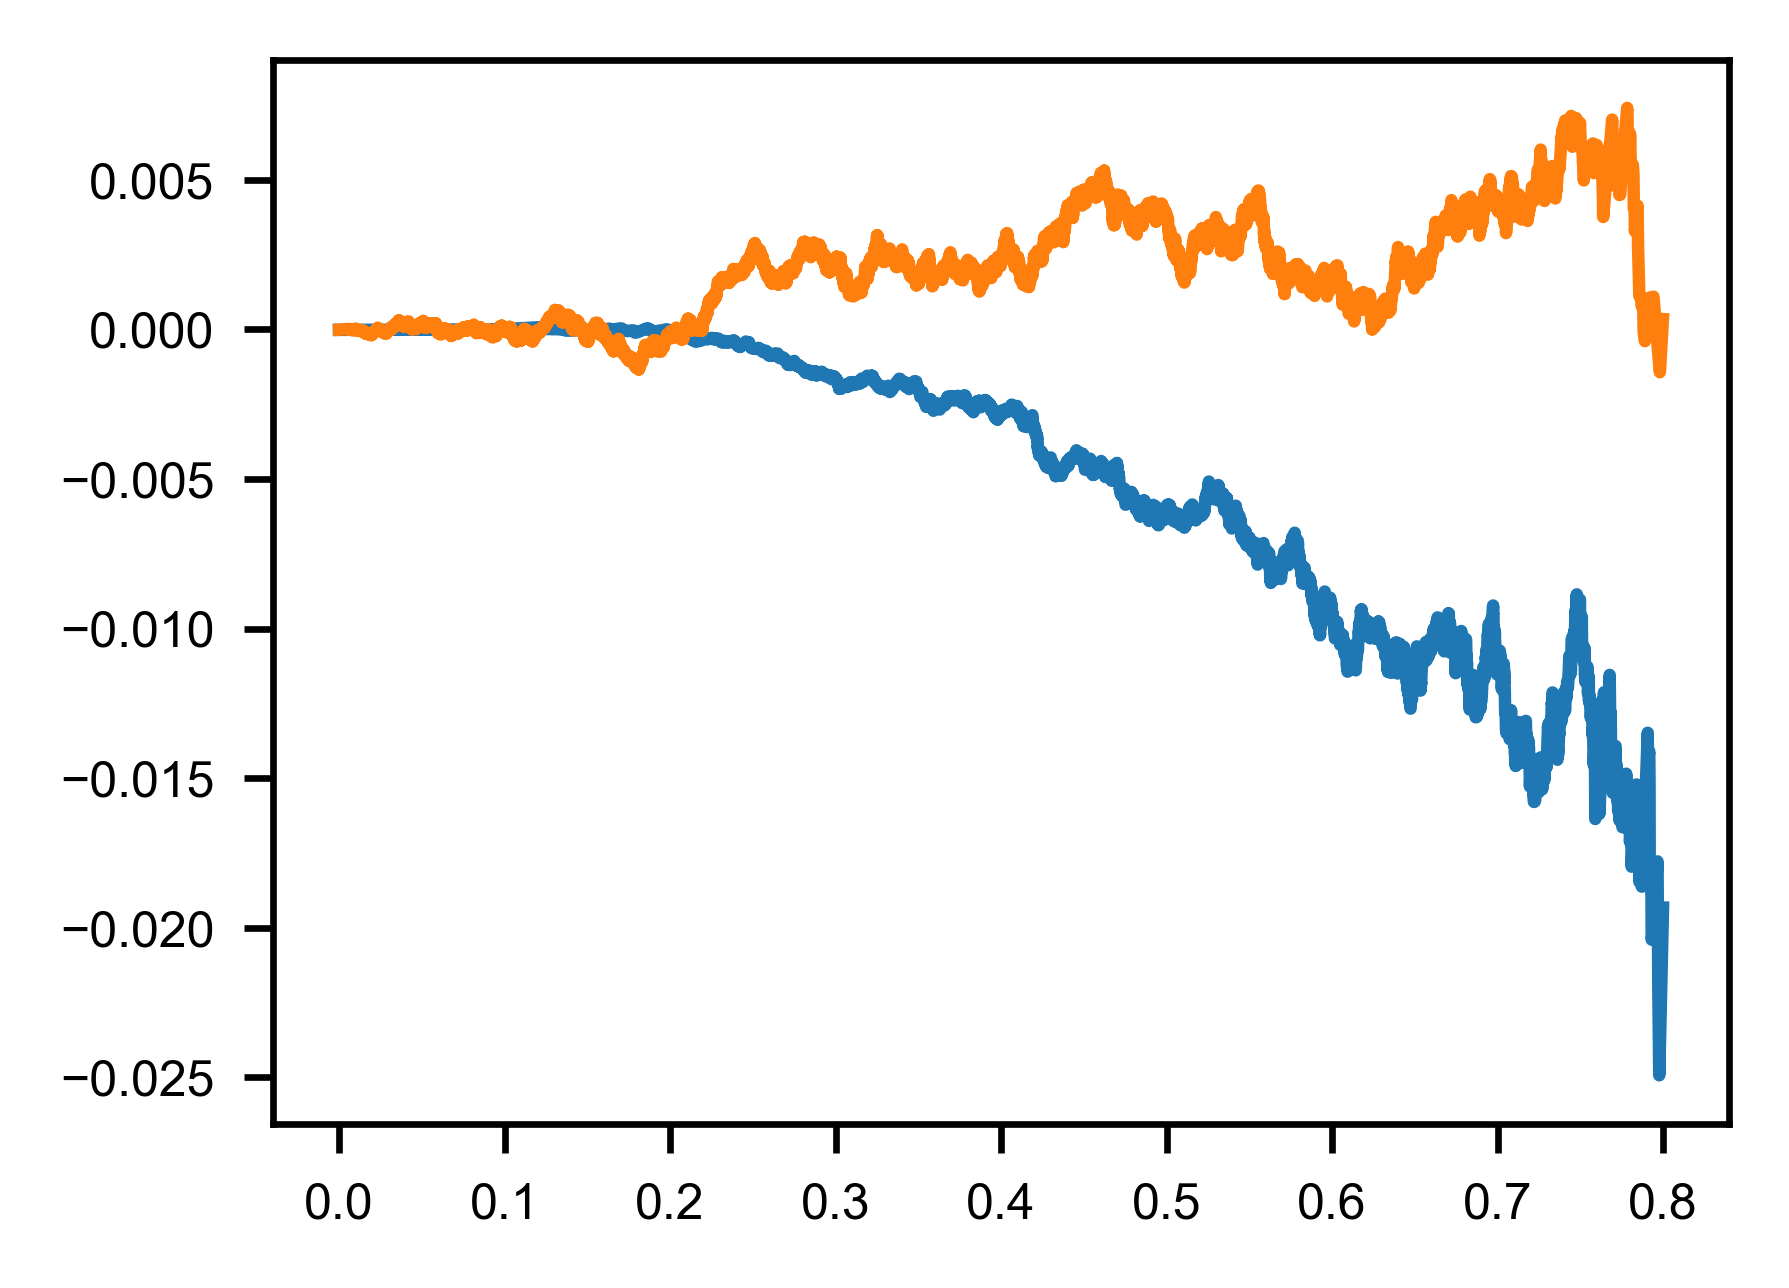

In [14]:
stats = mla.stats
traj_cols = ['replicate']
fig, ax = plt.subplots()
for var in var_pair:
    interior = obs.loc[
        (obs['state'] == var.name) & (obs['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    exterior = obs.loc[
            (obs['state'] == var.name)
            & (obs['wait_type'] != 'interior')
            & (obs['wait_type'] != 'full exterior'),
            ['wait_time', 'window_size']
    ].copy()
    window_sizes = obs.groupby(traj_cols)['window_size'].first().values
    # now sorted
    window_sizes, window_cdf = stats.ecdf(window_sizes)
    window_sf = 1 - window_cdf
    all_times, cdf_int, cdf_ext, Z_X, F_T = fw.ecdf_ext_int(
        exterior.wait_time.values,
        interior.wait_time.values,
        interior.window_size.values
    )
    err_ave[var.name] += (1/N_boot) * np.interp(err_t, all_times, var.cdf(all_times) - cdf_int*F_T) 